In [ ]:
import sys
if 'google.colab' in sys.modules:
    !pip install pyyaml==5.1
    !pip install 'git+https://github.com/facebookresearch/detectron2.git'
else:
    print("This code is intended to be run in Google Colab environment.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 13.3 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-uyw78bg8
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-uyw78bg8
  Resolved https://github.com/facebookresearch/detectron2.git to commit 5b72c27ae39f99db75d43f18fd1312e1ea934e60
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/5

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# import os
# import zipfile

# zip_file_path = '/content/food-recognition-2022.zip'

# destination_directory = '/content/drive/My Drive/Thesis/downloaded_data'

# if not os.path.exists(destination_directory):
#     os.makedirs(destination_directory)

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(destination_directory)

# print(f'Files extracted to {destination_directory}')

Files extracted to /content/drive/My Drive/Thesis/downloaded_data


In [ ]:

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import pandas as pd
import cv2
import json
from tqdm.notebook import tqdm
import subprocess
import time
from pathlib import Path

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import ColorMode
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.structures import Boxes, BoxMode
import pycocotools.mask as mask_util
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from pycocotools.coco import COCO

from pprint import pprint
from collections import OrderedDict
import os

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from google.colab.patches import cv2_imshow

In [ ]:
TRAIN_ANNOTATIONS_PATH = "/content/drive/My Drive/Thesis/downloaded_data/raw_data/public_training_set_release_2.0/annotations.json"
TRAIN_IMAGE_DIRECTORY = "/content/drive/My Drive/Thesis/downloaded_data/raw_data/public_training_set_release_2.0/images"

VAL_ANNOTATIONS_PATH = "/content/drive/My Drive/Thesis/downloaded_data/raw_data/public_validation_set_2.0/annotations.json"
VAL_IMAGE_DIRECTORY = "/content/drive/My Drive/Thesis/downloaded_data/raw_data/public_validation_set_2.0/images"

train_coco = COCO(TRAIN_ANNOTATIONS_PATH)

loading annotations into memory...
Done (t=8.29s)
creating index...
index created!


In [ ]:
with open(TRAIN_ANNOTATIONS_PATH) as f:
  train_annotations_data = json.load(f)

with open(VAL_ANNOTATIONS_PATH) as f:
  val_annotations_data = json.load(f)
train_annotations_data['annotations'][0]

{'id': 184135,
 'image_id': 131094,
 'category_id': 1352,
 'segmentation': [[115.0,
   206.5,
   98.0,
   204.5,
   74.5,
   182.0,
   65.0,
   167.5,
   47.5,
   156.0,
   39.5,
   137.0,
   39.5,
   130.0,
   51.0,
   118.5,
   62.00000000000001,
   112.5,
   76.0,
   113.5,
   121.5,
   151.0,
   130.5,
   169.0,
   131.5,
   185.0,
   128.5,
   195.0]],
 'area': 5059.0,
 'bbox': [39.5, 39.5, 167.0, 92.0],
 'iscrowd': 0}

In [ ]:
category_ids = train_coco.loadCats(train_coco.getCatIds())
category_names = [_["name_readable"] for _ in category_ids]

print("## Categories\n-", "\n- ".join(category_names))

## Categories
- Bread, wholemeal
- Jam
- Water
- Bread, sourdough
- Banana
- Soft cheese
- Ham, raw
- Hard cheese
- Cottage cheese
- Bread, half white
- Coffee, with caffeine
- Fruit salad
- Pancakes
- Tea
- Salmon, smoked
- Avocado
- Spring onion / scallion
- Ristretto, with caffeine
- Ham
- Egg
- Bacon, frying
- Chips, french fries
- Juice, apple
- Chicken
- Tomato, raw 
- Broccoli
- Shrimp, boiled
- Beetroot, steamed, without addition of salt
- Carrot, raw
- Chickpeas
- French salad dressing
- Pasta, Hörnli
- Sauce, cream
- Meat balls
- Pasta
- Tomato sauce
- Cheese
- Pear
- Cashew nut
- Almonds
- Lentils
- Mixed vegetables
- Peanut butter
- Apple
- Blueberries
- Cucumber
- Cocoa powder
- Greek Yaourt, yahourt, yogourt ou yoghourt
- Maple syrup (Concentrate)
- Buckwheat, grain peeled
- Butter
- Herbal tea
- Mayonnaise
- Soup, vegetable
- Wine, red
- Wine, white
- Green bean, steamed, without addition of salt
- Sausage
- Pizza, Margherita, baked
- Salami
- Mushroom
- (bread, meat sub

In [ ]:
from collections import OrderedDict

no_images_per_category = {}

category_names = [cat['name'] for cat in train_coco.loadCats(train_coco.getCatIds())]
for n, i in enumerate(train_coco.getCatIds()):
    imgIds = train_coco.getImgIds(catIds=i)
    label = category_names[n]
    no_images_per_category[label] = len(imgIds)

img_info = pd.DataFrame(train_coco.loadImgs(train_coco.getImgIds()))
no_images_per_category = OrderedDict(sorted(no_images_per_category.items(), key=lambda x: -1*x[1]))

top_5_categories = list(no_images_per_category.keys())[:5]

print("Top categories:")
print(top_5_categories)

top_5_catIds = []
for cat in top_5_categories:
    cat_ids = train_coco.getCatIds(catNms=[cat])
    if cat_ids:
        top_5_catIds.append(cat_ids[0])
    else:
        print(f"Warning: No category ID found for category '{cat}'")

img_info = pd.DataFrame(train_coco.loadImgs(train_coco.getImgIds(catIds=top_5_catIds)))

print("Top 5 Categories:")
for cat in top_5_categories:
    count = no_images_per_category.get(cat, 0)
    print(f"{cat}: {count}")


Top categories:
['water', 'salad-leaf-salad-green', 'bread-white', 'tomato-raw', 'butter']
Top 5 Categories:
water: 2928
salad-leaf-salad-green: 2002
bread-white: 1891
tomato-raw: 1865
butter: 1601


In [ ]:
def fix_data(annotations, directory, VERBOSE=False):
    for n, img_info in enumerate(tqdm(annotations['images'])):
        img_path = os.path.join(directory, img_info["file_name"])
        img = cv2.imread(img_path)

        if img is None:
            if VERBOSE:
                print(f"Failed to load image: {img_path}")
            continue

        if img.shape[0] != img_info['height'] or img.shape[1] != img_info['width']:
            annotations['images'][n]['height'] = img.shape[0]
            annotations['images'][n]['width'] = img.shape[1]
            if VERBOSE:
                print(f"Updated dimensions for image: {img_path}")
                print(f"Updated annotation: {annotations['images'][n]}, Actual shape: {img.shape}")

    return annotations

def filter_annotations_by_category(annotations, cat_ids):
    filtered_annotations = {
        'images': [],
        'annotations': [],
        'categories': []
    }

    for img_info in annotations['images']:
        img_id = img_info['id']
        ann_ids = train_coco.getAnnIds(imgIds=img_id, catIds=cat_ids, iscrowd=None)
        anns = train_coco.loadAnns(ann_ids)

        if len(anns) > 0:
            filtered_annotations['images'].append(img_info)
            filtered_annotations['annotations'].extend(anns)

    filtered_annotations['categories'] = [
        cat for cat in annotations['categories'] if cat['id'] in cat_ids
    ]

    return filtered_annotations

train_annotations_data = filter_annotations_by_category(train_annotations_data, top_5_catIds)
val_annotations_data = filter_annotations_by_category(val_annotations_data, top_5_catIds)

train_annotations_data = fix_data(train_annotations_data, TRAIN_IMAGE_DIRECTORY, VERBOSE=True)
val_annotations_data = fix_data(val_annotations_data, VAL_IMAGE_DIRECTORY, VERBOSE=True)
print(val_annotations_data)

with open('/content/drive/My Drive/Thesis/downloaded_data/raw_data/public_training_set_release_2.0/new_ann_top_5.json', 'w') as f:
    json.dump(train_annotations_data, f)

with open('/content/drive/My Drive/Thesis/downloaded_data/raw_data/public_validation_set_2.0/new_ann_top_5.json', 'w') as f:
    json.dump(val_annotations_data, f)


  0%|          | 0/9151 [00:00<?, ?it/s]

Updated dimensions for image: /content/drive/My Drive/Thesis/downloaded_data/raw_data/public_training_set_release_2.0/images/008618.jpg
Updated annotation: {'id': 8618, 'file_name': '008618.jpg', 'width': 3024, 'height': 4032}, Actual shape: (4032, 3024, 3)
Updated dimensions for image: /content/drive/My Drive/Thesis/downloaded_data/raw_data/public_training_set_release_2.0/images/008619.jpg
Updated annotation: {'id': 8619, 'file_name': '008619.jpg', 'width': 3024, 'height': 4032}, Actual shape: (4032, 3024, 3)
Updated dimensions for image: /content/drive/My Drive/Thesis/downloaded_data/raw_data/public_training_set_release_2.0/images/008621.jpg
Updated annotation: {'id': 8621, 'file_name': '008621.jpg', 'width': 3024, 'height': 4032}, Actual shape: (4032, 3024, 3)
Updated dimensions for image: /content/drive/My Drive/Thesis/downloaded_data/raw_data/public_training_set_release_2.0/images/008626.jpg
Updated annotation: {'id': 8626, 'file_name': '008626.jpg', 'width': 3024, 'height': 4032}

In [ ]:
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

register_coco_instances("training_dataset", {}, '/content/drive/My Drive/Thesis/downloaded_data/raw_data/public_training_set_release_2.0/new_ann_top_5.json', TRAIN_IMAGE_DIRECTORY)
register_coco_instances("validation_dataset", {}, '/content/drive/My Drive/Thesis/downloaded_data/raw_data/public_validation_set_2.0/new_ann_top_5.json', VAL_IMAGE_DIRECTORY)

train_metadata = MetadataCatalog.get("training_dataset")
train = DatasetCatalog.get("training_dataset")


[08/25 17:23:00 d2.data.datasets.coco]: Loading /content/drive/My Drive/Thesis/downloaded_data/raw_data/public_training_set_release_2.0/new_ann_top_5.json takes 2.43 seconds.
WARNING [08/25 17:23:00 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/25 17:23:00 d2.data.datasets.coco]: Loaded 9151 images in COCO format from /content/drive/My Drive/Thesis/downloaded_data/raw_data/public_training_set_release_2.0/new_ann_top_5.json


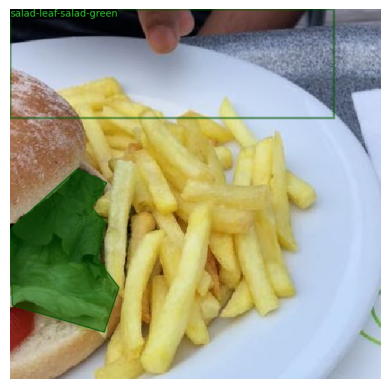

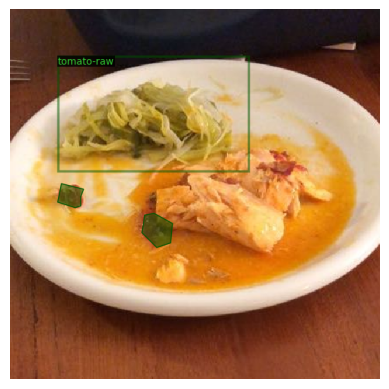

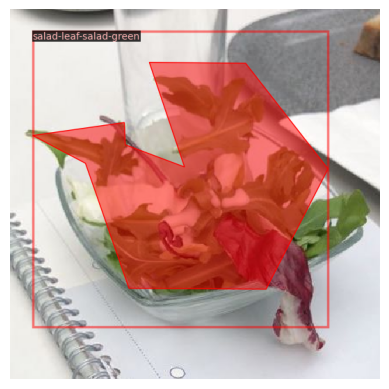

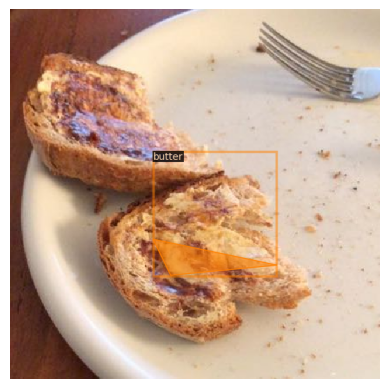

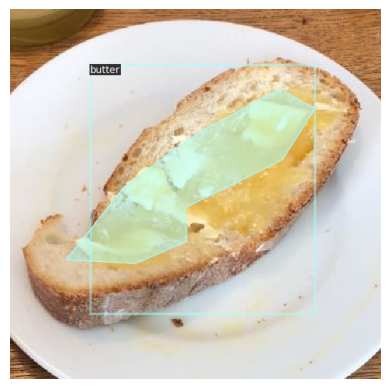

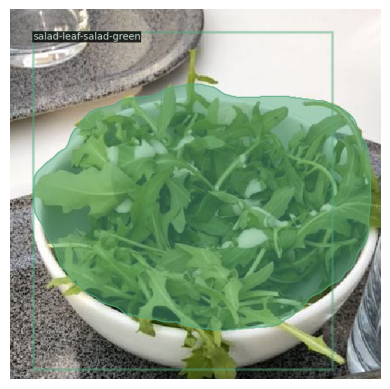

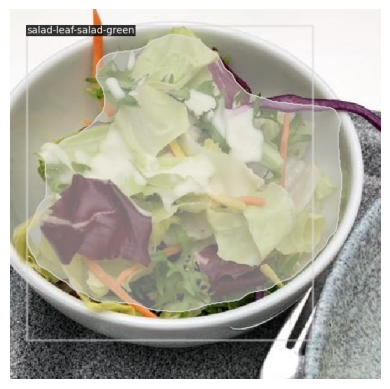

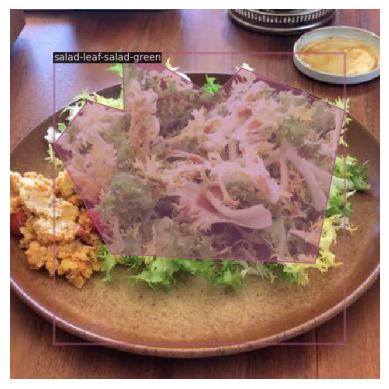

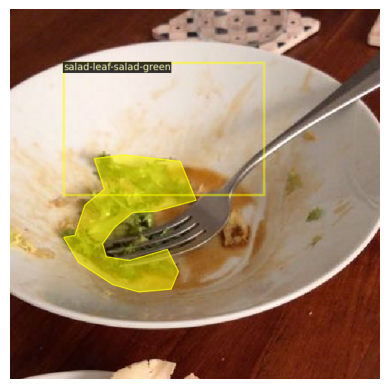

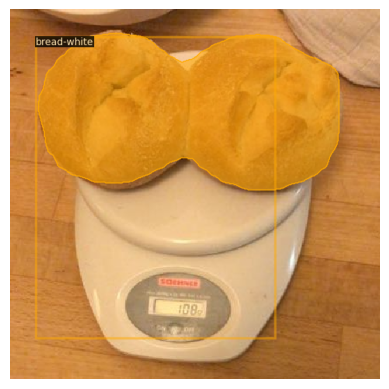

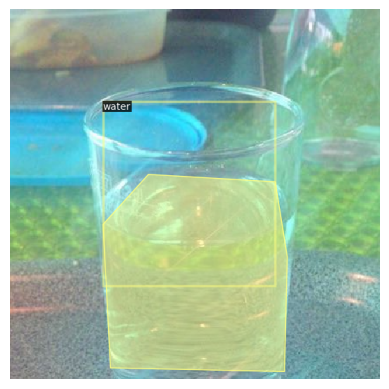

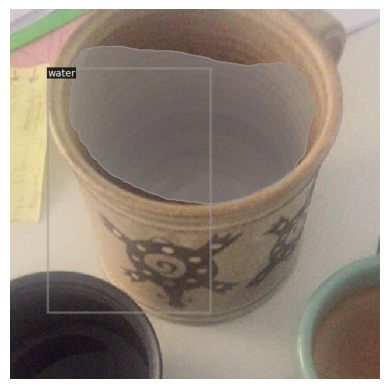

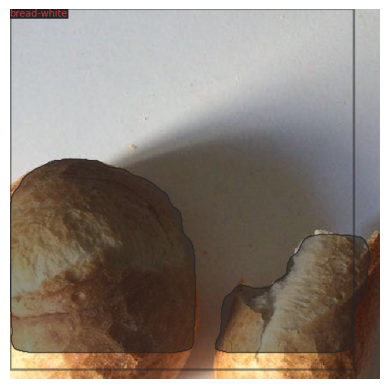

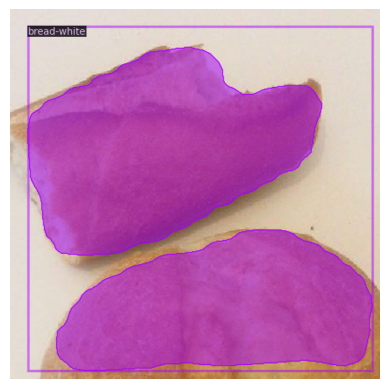

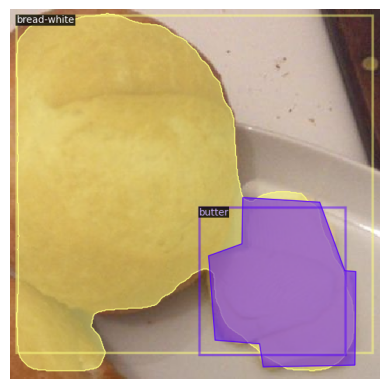

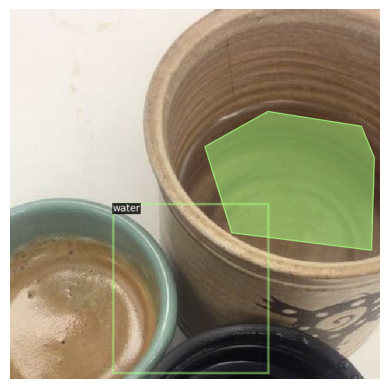

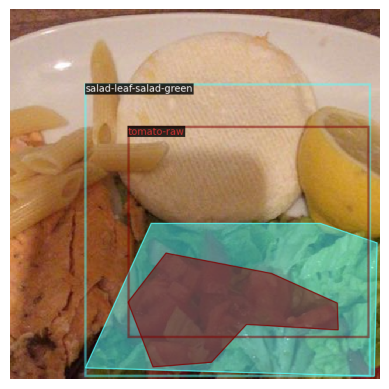

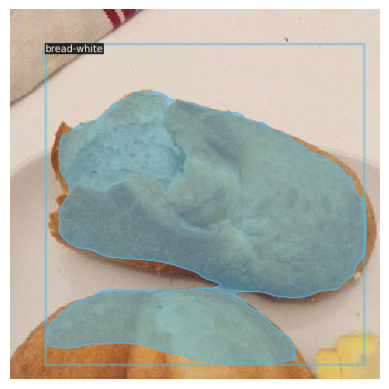

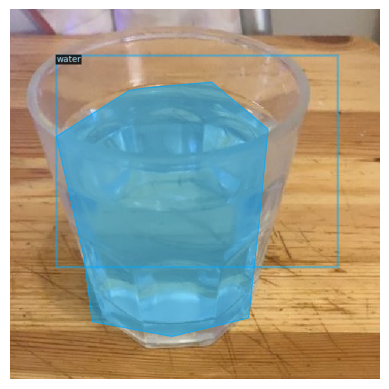

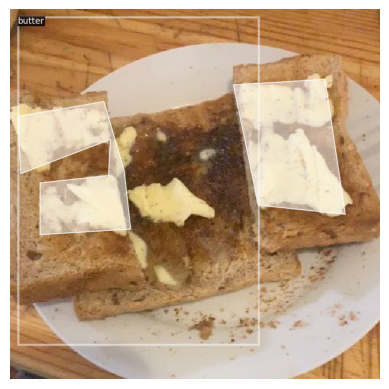

In [ ]:
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
import matplotlib.pyplot as plt
from PIL import Image

def visualize_samples(dataset_dicts, metadata, num_samples=20):
    for d in dataset_dicts[:num_samples]:
        img = Image.open(d['file_name'])
        visualizer = Visualizer(img, scale=1.25, metadata=metadata, instance_mode=ColorMode.IMAGE)
        out = visualizer.draw_dataset_dict(d)
        plt.imshow(out.get_image())
        plt.axis('off')
        plt.show()

visualize_samples(train, train_metadata)


In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

MODEL_ARCH = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(MODEL_ARCH))
cfg.DATASETS.TRAIN = ("training_dataset",)
cfg.DATASETS.TEST = ("validation_dataset",)
cfg.DATALOADER.NUM_WORKERS = 2

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL_ARCH)
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR"
cfg.SOLVER.CHECKPOINT_PERIOD = 1000

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256

cfg.OUTPUT_DIR = "/content/drive/My Drive/model/logs_detectron2_r50"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

RESUME = False
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=RESUME)

trainer.train()


[08/26 09:06:17 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[08/26 09:09:42 d2.utils.events]:  eta: 2:09:48  iter: 8019  total_loss: 0.5415  loss_cls: 0.1279  loss_box_reg: 0.2029  loss_mask: 0.1691  loss_rpn_cls: 0.005386  loss_rpn_loc: 0.006507    time: 3.5155  last_time: 1.8374  data_time: 8.3718  last_data_time: 1.1178   lr: 0.001  max_mem: 6052M
[08/26 09:10:53 d2.utils.events]:  eta: 2:14:10  iter: 8039  total_loss: 0.5094  loss_cls: 0.1303  loss_box_reg: 0.1971  loss_mask: 0.1869  loss_rpn_cls: 0.006551  loss_rpn_loc: 0.005807    time: 3.4401  last_time: 1.2730  data_time: 2.6417  last_data_time: 0.5232   lr: 0.001  max_mem: 8046M
[08/26 09:12:03 d2.utils.events]:  eta: 2:06:49  iter: 8059  total_loss: 0.5315  loss_cls: 0.1328  loss_box_reg: 0.2113  loss_mask: 0.162  loss_rpn_cls: 0.005653  loss_rpn_loc: 0.00659    time: 3.4522  last_time: 4.6191  data_time: 2.7294  last_data_time: 3.8891   lr: 0.001  max_mem: 8046M
[08/26 09:13:13 d2.utils.events]:  eta: 1:57:56  iter: 8079  total_loss: 0.5273  loss_cls: 0.1297  loss_box_reg: 0.2089  lo

In [ ]:
from detectron2.evaluation import COCOEvaluator
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.001
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.2
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

predictor = DefaultPredictor(cfg)
val_loader = build_detection_test_loader(cfg, "validation_dataset")

evaluator = COCOEvaluator("validation_dataset", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_results = inference_on_dataset(trainer.model, val_loader, evaluator)


[08/25 12:44:49 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/My Drive/model/logs_detectron2_r50/model_final.pth ...
WARNING [08/25 12:44:49 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/25 12:44:49 d2.data.datasets.coco]: Loaded 239 images in COCO format from /content/drive/My Drive/Thesis/downloaded_data/raw_data/public_validation_set_2.0/new_ann_top_5.json
[08/25 12:44:49 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/25 12:44:49 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/25 12:44:49 d2.data.common]: Serializing 239 elements to byte tensors and concatenating them all ...
[08/25 12:44:49 d2.data.common]: Serialized dataset takes 0.25 MiB
WARNING [08/25 12:44:49 d2.evaluation.coco_evaluation]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[08/25 12:44:54 d2.evaluation.evaluator]: Inference done 11/239. Dataloading: 0.3430 s/iter. Inference: 0.0435 s/iter. Eval: 0.0192 s/iter. Total: 0.4057 s/iter. ETA=0:01:32
[08/25 12:44:59 d2.evaluation.evaluator]: Inference done 23/239. Dataloading: 0.3673 s/iter. Inference: 0.0431 s/iter. Eval: 0.0135 s/iter. Total: 0.4240 s/iter. ETA=0:01:31
[08/25 12:45:05 d2.evaluation.evaluator]: Inference done 35/239. Dataloading: 0.3742 s/iter. Inference: 0.0451 s/iter. Eval: 0.0133 s/iter. Total: 0.4327 s/iter. ETA=0:01:28
[08/25 12:45:10 d2.evaluation.evaluator]: Inference done 47/239. Dataloading: 0.3772 s/iter. Inference: 0.0433 s/iter. Eval: 0.0115 s/iter. Total: 0.4321 s/iter. ETA=0:01:22
[08/25 12:45:16 d2.evaluation.evaluator]: Inference done 61/239. Dataloading: 0.3724 s/iter. Inference: 0.0420 s/iter. Eval: 0.0113 s/iter. Total: 0.4259 s/iter. ETA=0:01:15
[08/25 12:45:21 d2.evaluation.evaluator]: Inference done 75/239. Dataloading: 0.3655 s/iter. Inference: 0.0430 s/iter. Eval: 0.011

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json
import os

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.001
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.2
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

predictor = DefaultPredictor(cfg)
val_loader = build_detection_test_loader(cfg, "validation_dataset")

evaluator = COCOEvaluator("validation_dataset", cfg, False, output_dir=cfg.OUTPUT_DIR)
inference_on_dataset(predictor.model, val_loader, evaluator)

results_json = os.path.join(cfg.OUTPUT_DIR, "coco_instances_results.json")
coco_gt = COCO(os.path.join("/content/drive/My Drive/Thesis/downloaded_data/raw_data/public_validation_set_2.0/", "new_ann_top_5.json"))
coco_dt = coco_gt.loadRes(results_json)

iou_thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]


for iou_thresh in iou_thresholds:
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='segm')
    coco_eval.params.iouThrs = [iou_thresh]

    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    print(f"Results for IoU threshold = {iou_thresh}")
    print(coco_eval.stats)


[08/25 20:58:19 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/My Drive/model/logs_detectron2_r50/model_final.pth ...
WARNING [08/25 20:58:19 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/25 20:58:19 d2.data.datasets.coco]: Loaded 239 images in COCO format from /content/drive/My Drive/Thesis/downloaded_data/raw_data/public_validation_set_2.0/new_ann_top_5.json
[08/25 20:58:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/25 20:58:19 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/25 20:58:19 d2.data.common]: Serializing 239 elements to byte tensors and concatenating them all ...
[08/25 20:58:19 d2.data.common]: Serialized dataset takes 0.25 MiB
WARNING [08/25 20:58:19 d2.evaluation.coco_evaluation]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[08/25 20:58:20 d2.evaluation.evaluator]: Inference done 11/239. Dataloading: 0.0014 s/iter. Inference: 0.0503 s/iter. Eval: 0.0728 s/iter. Total: 0.1245 s/iter. ETA=0:00:28
[08/25 20:58:26 d2.evaluation.evaluator]: Inference done 78/239. Dataloading: 0.0016 s/iter. Inference: 0.0446 s/iter. Eval: 0.0327 s/iter. Total: 0.0789 s/iter. ETA=0:00:12
[08/25 20:58:31 d2.evaluation.evaluator]: Inference done 143/239. Dataloading: 0.0015 s/iter. Inference: 0.0447 s/iter. Eval: 0.0318 s/iter. Total: 0.0781 s/iter. ETA=0:00:07
[08/25 20:58:36 d2.evaluation.evaluator]: Inference done 201/239. Dataloading: 0.0015 s/iter. Inference: 0.0449 s/iter. Eval: 0.0347 s/iter. Total: 0.0812 s/iter. ETA=0:00:03
[08/25 20:58:41 d2.evaluation.evaluator]: Inference done 239/239. Dataloading: 0.0015 s/iter. Inference: 0.0460 s/iter. Eval: 0.0419 s/iter. Total: 0.0895 s/iter. ETA=0:00:00
[08/25 20:58:41 d2.evaluation.evaluator]: Total inference time: 0:00:21.036210 (0.089898 s / iter per device, on 1 devices)
[08

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import os

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.001
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.2
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

predictor = DefaultPredictor(cfg)
val_loader = build_detection_test_loader(cfg, "validation_dataset")

evaluator = COCOEvaluator("validation_dataset", cfg, False, output_dir=cfg.OUTPUT_DIR)
inference_on_dataset(predictor.model, val_loader, evaluator)

results_json = os.path.join(cfg.OUTPUT_DIR, "coco_instances_results.json")
coco_gt = COCO(os.path.join("/content/drive/My Drive/Thesis/downloaded_data/raw_data/public_validation_set_2.0/", "new_ann_top_5.json"))
coco_dt = coco_gt.loadRes(results_json)

coco_eval = COCOeval(coco_gt, coco_dt, iouType='segm')

coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

iou_thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
for iou_thresh in iou_thresholds:
    print(f"\nResults for IoU threshold = {iou_thresh}")

    coco_eval = COCOeval(coco_gt, coco_dt, iouType='segm')
    coco_eval.params.iouThrs = [iou_thresh]

    coco_eval.evaluate()
    coco_eval.accumulate()

    if coco_eval.stats is not None and len(coco_eval.stats) > 0:
        mAP = coco_eval.stats[0] * 100
        print(f"mAP at IoU {iou_thresh}: {mAP:.2f}%")
    else:
        print(f"No valid detections at IoU {iou_thresh}. mAP cannot be calculated.")

    print(f"{'Category':<25} {'AP':<10}")
    print('-' * 35)
    for idx, catId in enumerate(coco_gt.getCatIds()):
        category_name = coco_gt.loadCats(catId)[0]["name"]
        precision = coco_eval.eval['precision']
        if precision.size > 0:
            ap = precision[0, :, idx, 0, -1].mean() * 100
            print(f"{category_name:<25} {ap:.2f}%")
        else:
            print(f"{category_name:<25} No valid detections")

    coco_eval.summarize()

[08/25 20:58:46 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/My Drive/model/logs_detectron2_r50/model_final.pth ...
WARNING [08/25 20:58:47 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/25 20:58:47 d2.data.datasets.coco]: Loaded 239 images in COCO format from /content/drive/My Drive/Thesis/downloaded_data/raw_data/public_validation_set_2.0/new_ann_top_5.json
[08/25 20:58:47 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/25 20:58:47 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/25 20:58:47 d2.data.common]: Serializing 239 elements to byte tensors and concatenating them all ...
[08/25 20:58:47 d2.data.common]: Serialized dataset takes 0.25 MiB
WARNING [08/25 20:58:47 d2.evaluation.coco_evaluation]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[08/25 20:58:48 d2.evaluation.evaluator]: Inference done 11/239. Dataloading: 0.0013 s/iter. Inference: 0.0478 s/iter. Eval: 0.0694 s/iter. Total: 0.1185 s/iter. ETA=0:00:27
[08/25 20:58:53 d2.evaluation.evaluator]: Inference done 79/239. Dataloading: 0.0015 s/iter. Inference: 0.0437 s/iter. Eval: 0.0322 s/iter. Total: 0.0775 s/iter. ETA=0:00:12
[08/25 20:58:58 d2.evaluation.evaluator]: Inference done 147/239. Dataloading: 0.0015 s/iter. Inference: 0.0431 s/iter. Eval: 0.0314 s/iter. Total: 0.0761 s/iter. ETA=0:00:07
[08/25 20:59:03 d2.evaluation.evaluator]: Inference done 202/239. Dataloading: 0.0015 s/iter. Inference: 0.0439 s/iter. Eval: 0.0349 s/iter. Total: 0.0803 s/iter. ETA=0:00:02
[08/25 20:59:08 d2.evaluation.evaluator]: Total inference time: 0:00:20.550691 (0.087823 s / iter per device, on 1 devices)
[08/25 20:59:08 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:10 (0.044438 s / iter per device, on 1 devices)
[08/25 20:59:08 d2.evaluation.coco_evaluation]: 

mAP


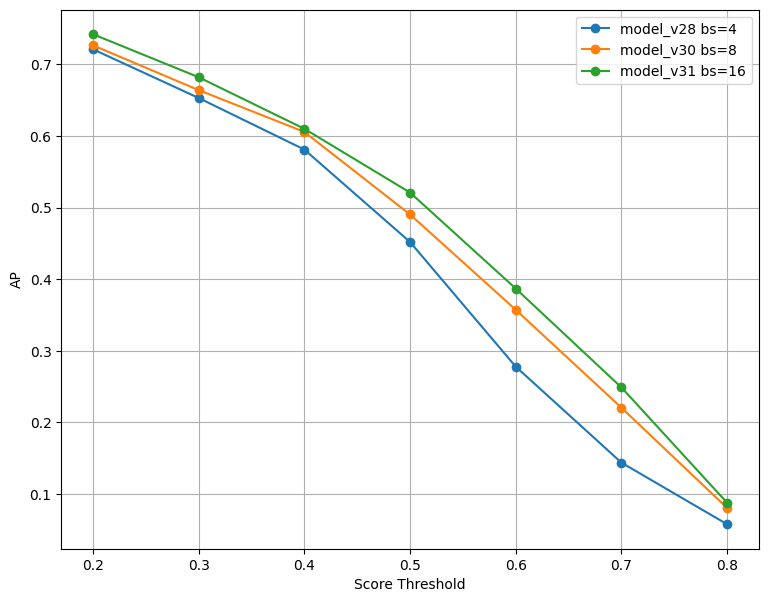

Water


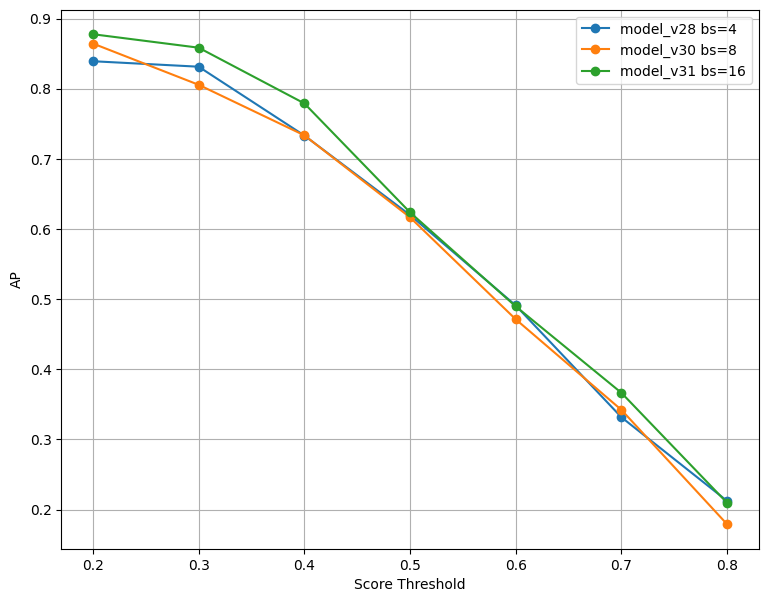

Tomato


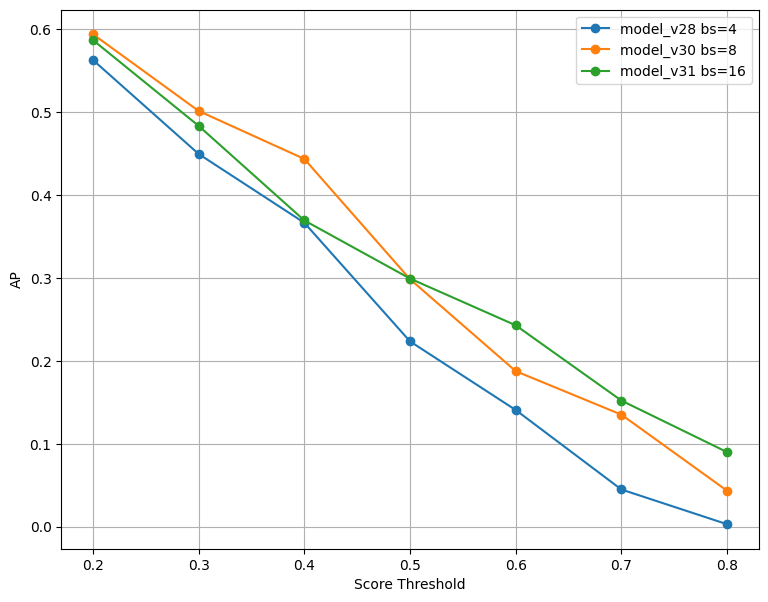

Butter


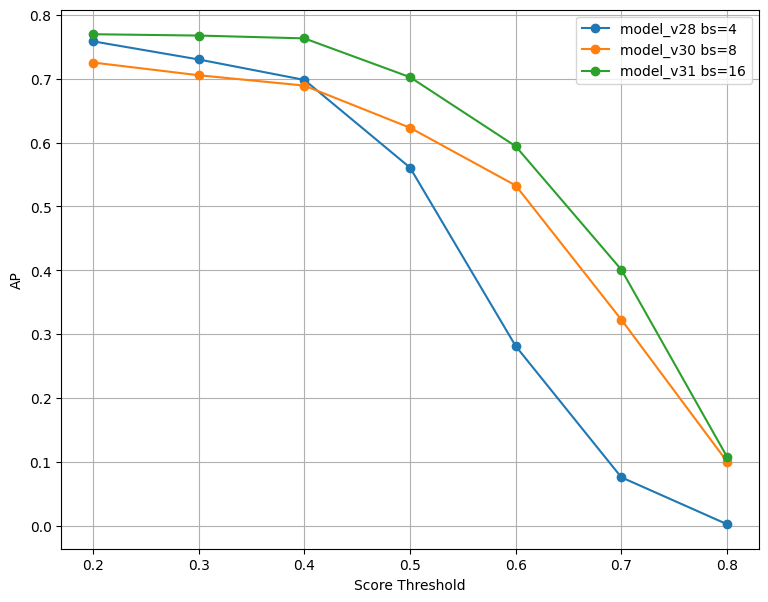

Salad


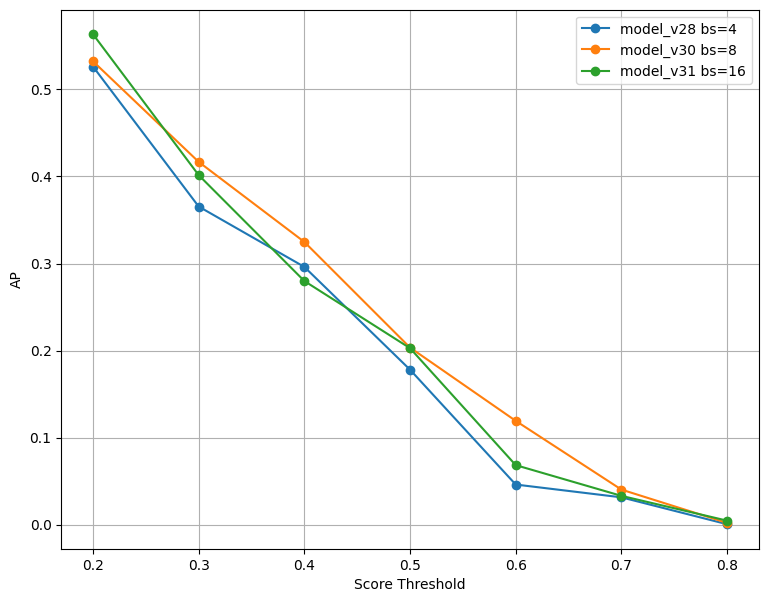

Bread


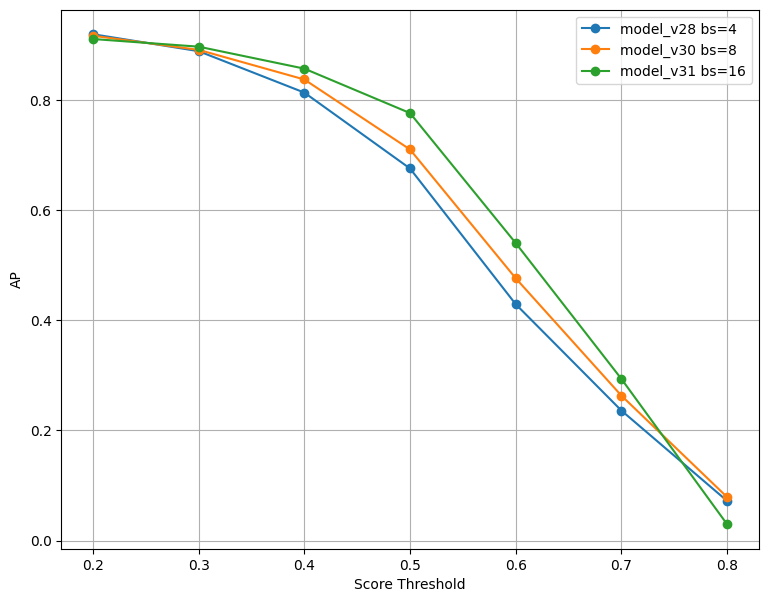

In [ ]:
import matplotlib.pyplot as plt

#batch size
#bbox values

score_thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

water_values = {
    "model_v28 bs=4": [0.8391, 0.8313, 0.7332, 0.6199, 0.4910, 0.3317, 0.2124],
    "model_v30 bs=8": [0.8643, 0.8055, 0.7335, 0.6166, 0.4713, 0.3422, 0.1792],
    "model_v31 bs=16": [0.8776, 0.8584, 0.7790, 0.6237, 0.4897, 0.3665, 0.2097]
}

tomato_values = {
    "model_v28 bs=4": [0.5630, 0.4496, 0.3666, 0.2235, 0.1407, 0.0448, 0.0029],
    "model_v30 bs=8": [0.5941, 0.5015, 0.4436, 0.2985, 0.1876, 0.1351, 0.0433],
    "model_v31 bs=16": [0.5870, 0.4835, 0.3694, 0.2993, 0.2429, 0.1521, 0.0899]
}

butter_values = {
    "model_v28 bs=4": [0.7584, 0.7300, 0.6980, 0.5607, 0.2813, 0.0759, 0.0025],
    "model_v30 bs=8": [0.7252, 0.7053, 0.6891, 0.6231, 0.5327, 0.3226, 0.1004],
    "model_v31 bs=16": [0.7695, 0.7674, 0.7630, 0.7023, 0.5941, 0.4009, 0.1079]
}

salad_values = {
    "model_v28 bs=4": [0.5264, 0.3655, 0.2961, 0.1780, 0.0460, 0.0313, 0.0004],
    "model_v30 bs=8": [0.5324, 0.4168, 0.3248, 0.2034, 0.1192, 0.0402, 0.0019],
    "model_v31 bs=16": [0.5635, 0.4016, 0.2799, 0.2027, 0.0683, 0.0330, 0.0045]
}

bread_values = {
    "model_v28 bs=4": [0.9194, 0.8886, 0.8134, 0.6756, 0.4292, 0.2361, 0.0721],
    "model_v30 bs=8": [0.9166, 0.8910, 0.8372, 0.7101, 0.4763, 0.2632, 0.0790],
    "model_v31 bs=16": [0.9107, 0.8968, 0.8569, 0.7762, 0.5402, 0.2936, 0.0297]
}

mAP_values = {
    "model_v28 bs=4": [0.721, 0.653, 0.581, 0.452, 0.278, 0.144, 0.058],
    "model_v30 bs=8": [0.7265, 0.6640, 0.6056, 0.4904, 0.3574, 0.2207, 0.0807],
    "model_v31 bs=16": [0.742, 0.682, 0.610, 0.521, 0.387, 0.249, 0.088],
}

all_values = {
    "mAP": mAP_values,
    "Water": water_values,
    "Tomato": tomato_values,
    "Butter": butter_values,
    "Salad": salad_values,
    "Bread": bread_values,
}

for category_name, values in all_values.items():
    print(category_name)
    plt.figure(figsize=(9, 7))
    for model_name, AP in values.items():
        plt.plot(score_thresholds, AP, marker='o', label=model_name)
    plt.xlabel("Score Threshold")
    plt.ylabel("AP")
    plt.grid(True)
    plt.legend()
    plt.show()


mAP


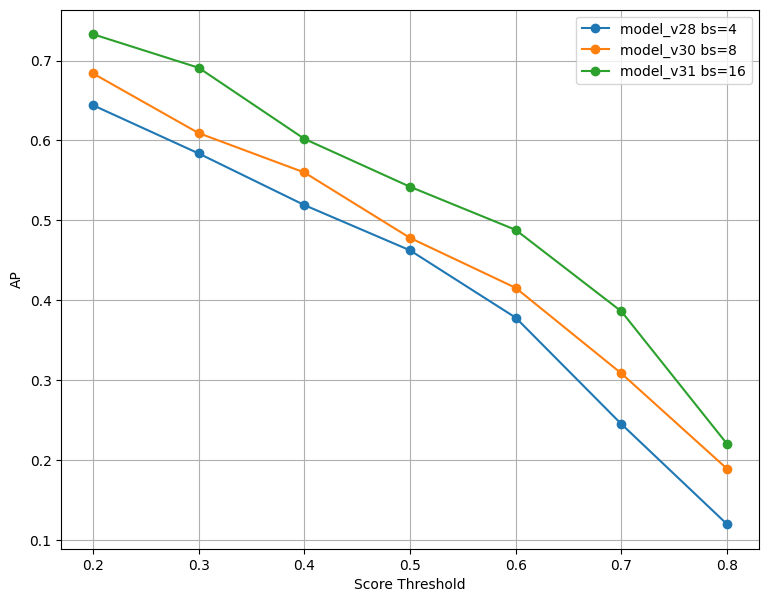

Water


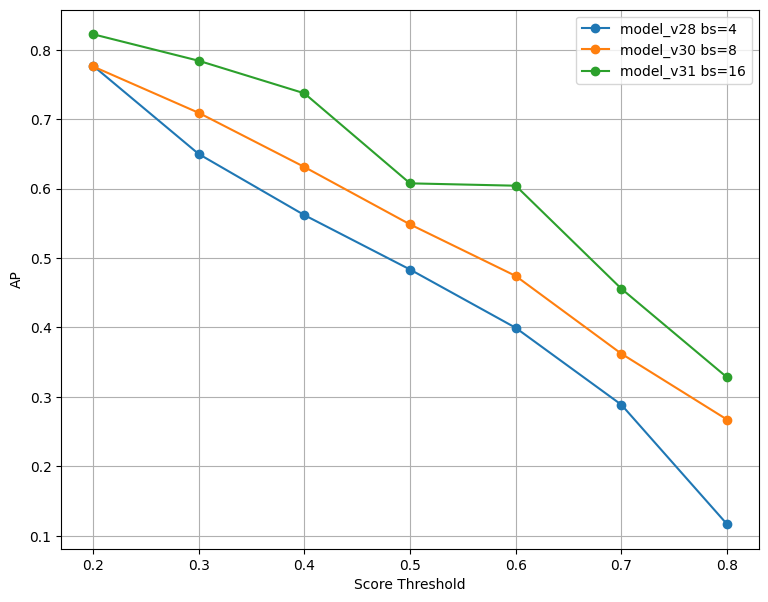

Tomato


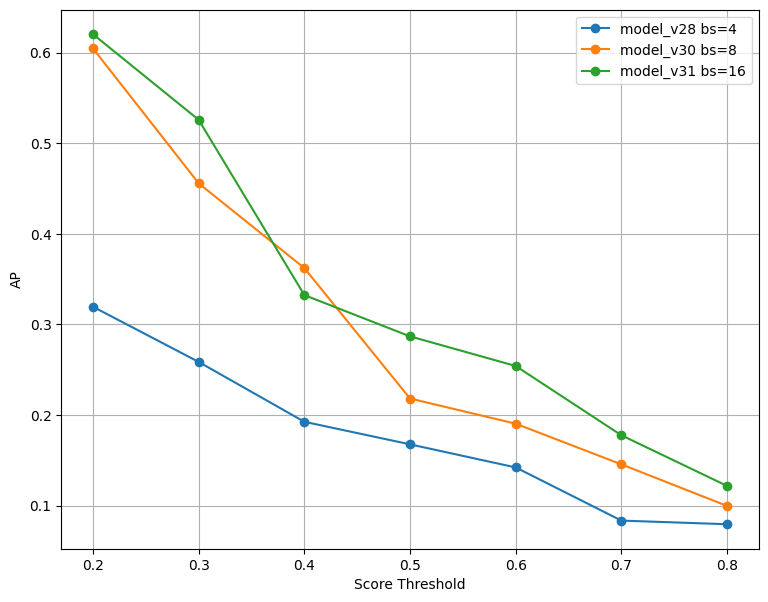

Butter


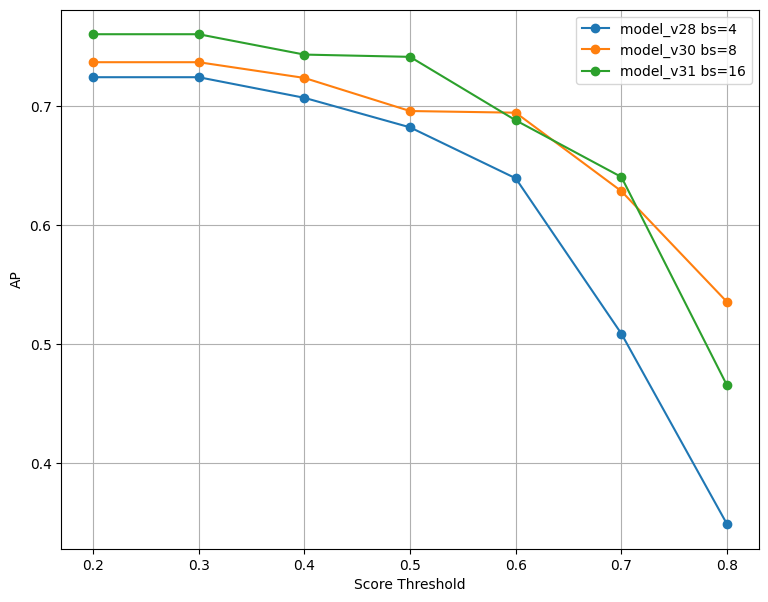

Salad


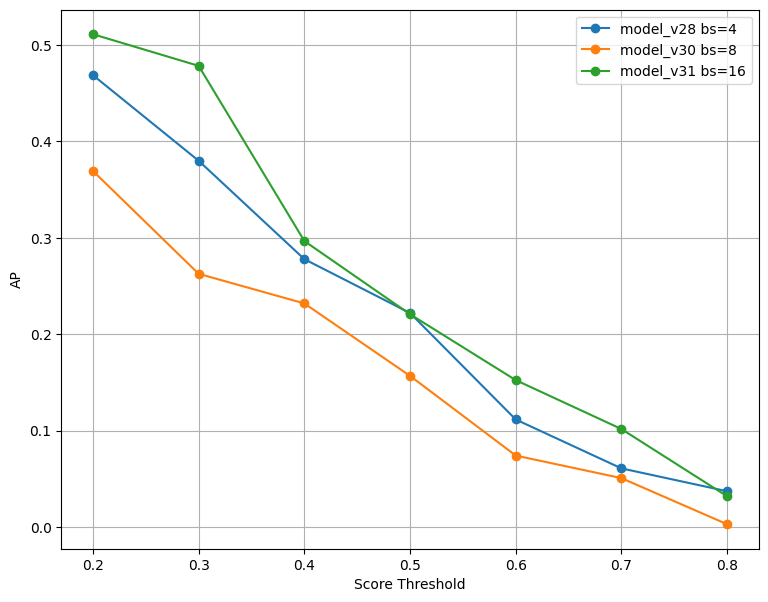

Bread


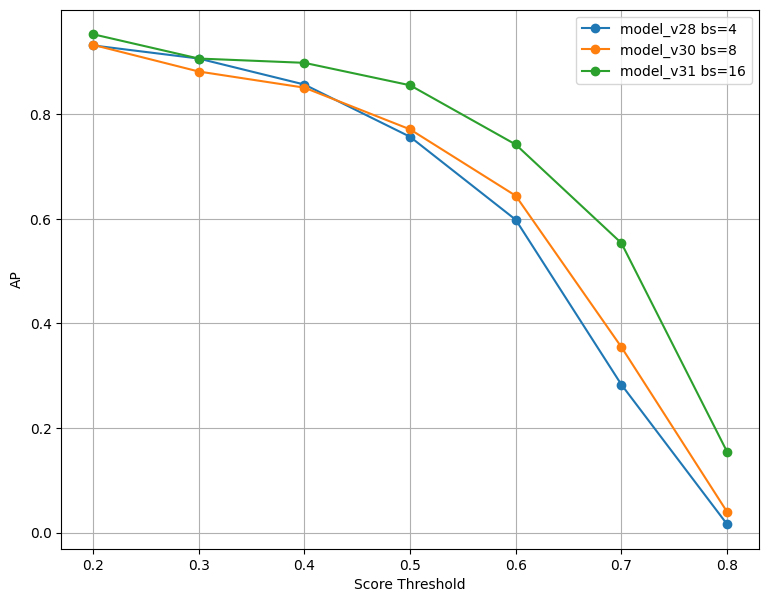

In [ ]:
import matplotlib.pyplot as plt

#batch size
#segmentation values


score_thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]


water_values = {
    "model_v28 bs=4": [0.7771, 0.6499, 0.5619, 0.4835, 0.3995, 0.2887, 0.1166],
    "model_v30 bs=8": [0.7760, 0.7092, 0.6312, 0.5485, 0.4742, 0.3622, 0.2673],
    "model_v31 bs=16": [0.8224, 0.7842, 0.7373, 0.6076, 0.6042, 0.4558, 0.3281]
}

tomato_values = {
    "model_v28 bs=4": [0.3195, 0.2586, 0.1925, 0.1676, 0.1421, 0.0834, 0.0794],
    "model_v30 bs=8": [0.6047, 0.4558, 0.3622, 0.2182, 0.1904, 0.1455, 0.0996],
    "model_v31 bs=16": [0.6204, 0.5259, 0.3324, 0.2868, 0.2541, 0.1776, 0.1217]
}

butter_values = {
    "model_v28 bs=4": [0.7240, 0.7240, 0.7067, 0.6819, 0.6391, 0.5086, 0.3486],
    "model_v30 bs=8": [0.7366, 0.7366, 0.7234, 0.6956, 0.6942, 0.6283, 0.5352],
    "model_v31 bs=16": [0.7601, 0.7601, 0.7430, 0.7411, 0.6878, 0.6402, 0.4651]
}

salad_values = {
    "model_v28 bs=4": [0.4685, 0.3798, 0.2778, 0.2220, 0.1116, 0.0609, 0.0372],
    "model_v30 bs=8": [0.3692, 0.2626, 0.2319, 0.1568, 0.0742, 0.0508, 0.0030],
    "model_v31 bs=16": [0.5110, 0.4782, 0.2966, 0.2207, 0.1524, 0.1017, 0.0320]
}

bread_values = {
    "model_v28 bs=4": [0.9316, 0.9065, 0.8568, 0.7569, 0.5982, 0.2829, 0.0159],
    "model_v30 bs=8": [0.9327, 0.8817, 0.8508, 0.7711, 0.6441, 0.3547, 0.0396],
    "model_v31 bs=16": [0.9530, 0.9065, 0.8983, 0.8554, 0.7421, 0.5536, 0.1545]
}

mAP_values = {
    "model_v28 bs=4": [0.6441, 0.5837, 0.5191, 0.4624, 0.3781, 0.2449, 0.1195],
    "model_v30 bs=8": [0.6839, 0.6092, 0.5599, 0.4780, 0.4154, 0.3083, 0.1889],
    "model_v31 bs=16": [0.733, 0.691, 0.602, 0.542, 0.488, 0.386, 0.220],
}

all_values = {
    "mAP": mAP_values,
    "Water": water_values,
    "Tomato": tomato_values,
    "Butter": butter_values,
    "Salad": salad_values,
    "Bread": bread_values,
}

for category_name, values in all_values.items():
    print(category_name)
    plt.figure(figsize=(9, 7))
    for model_name, AP in values.items():
        plt.plot(score_thresholds, AP, marker='o', label=model_name)
    plt.xlabel("Score Threshold")
    plt.ylabel("AP")
    plt.grid(True)
    plt.legend()
    plt.show()


mAP


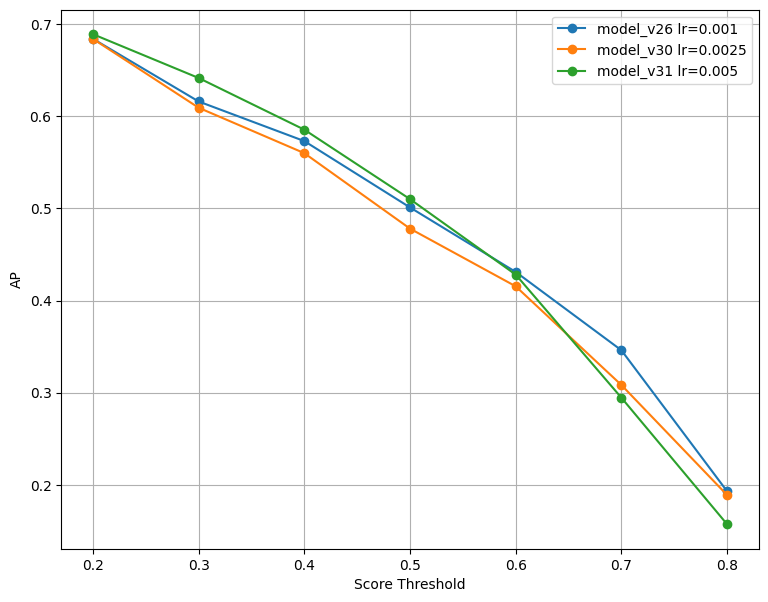

Water


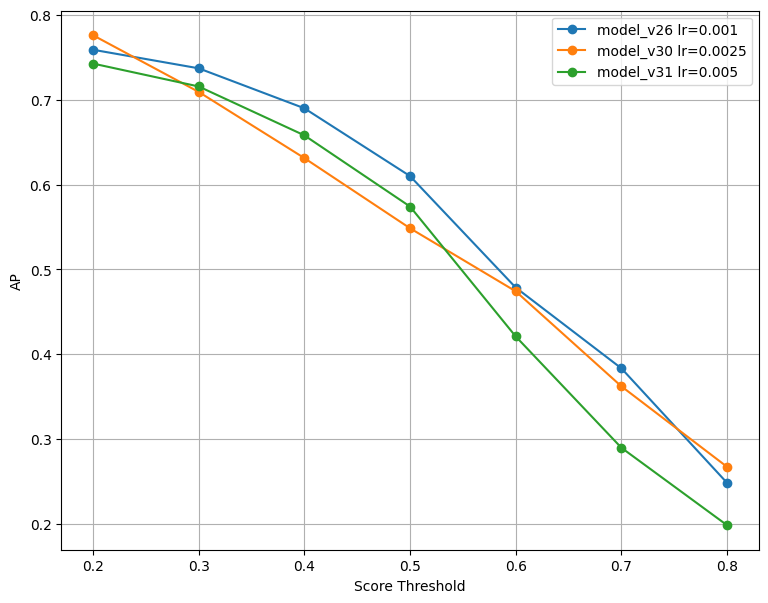

Tomato


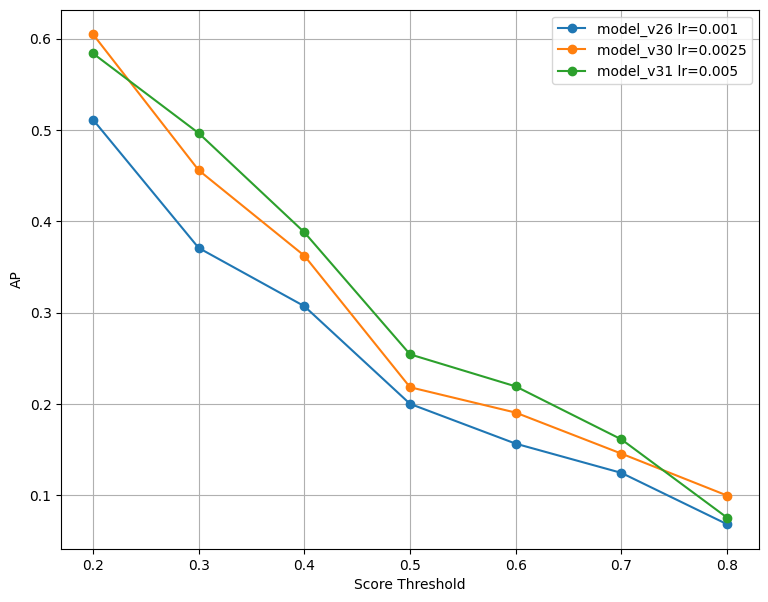

Butter


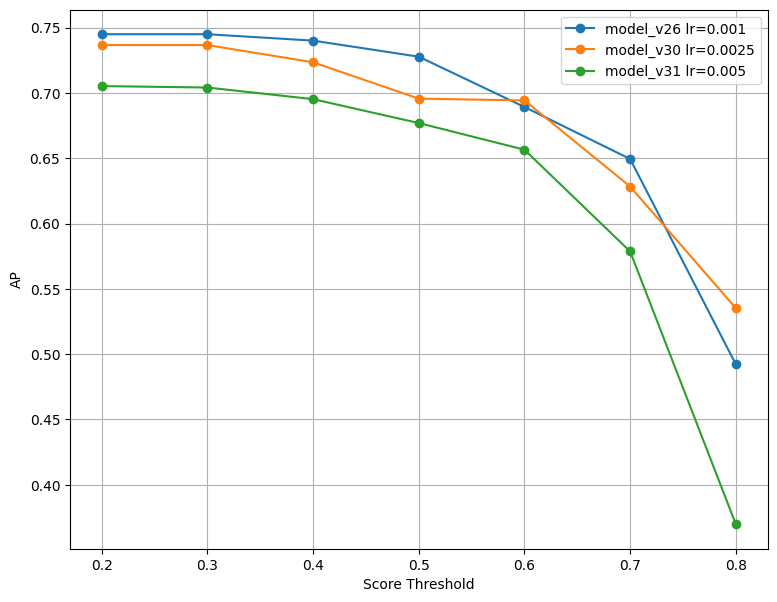

Salad


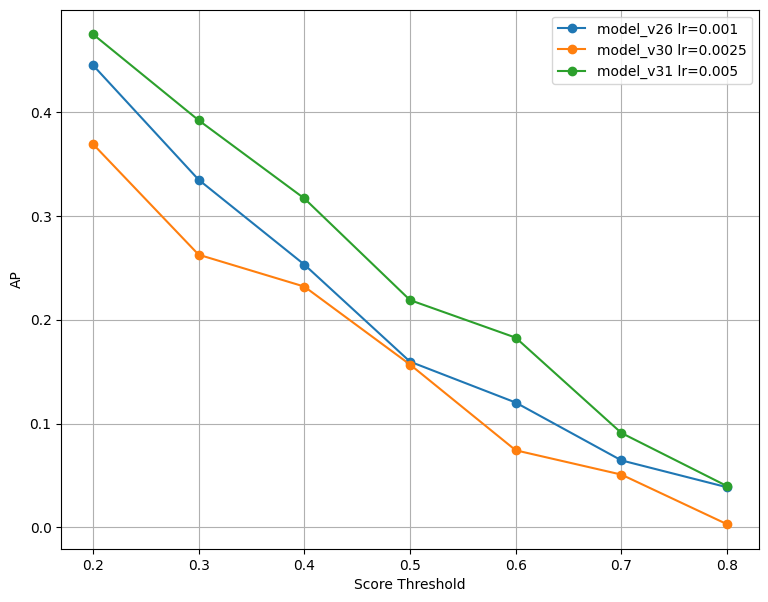

Bread


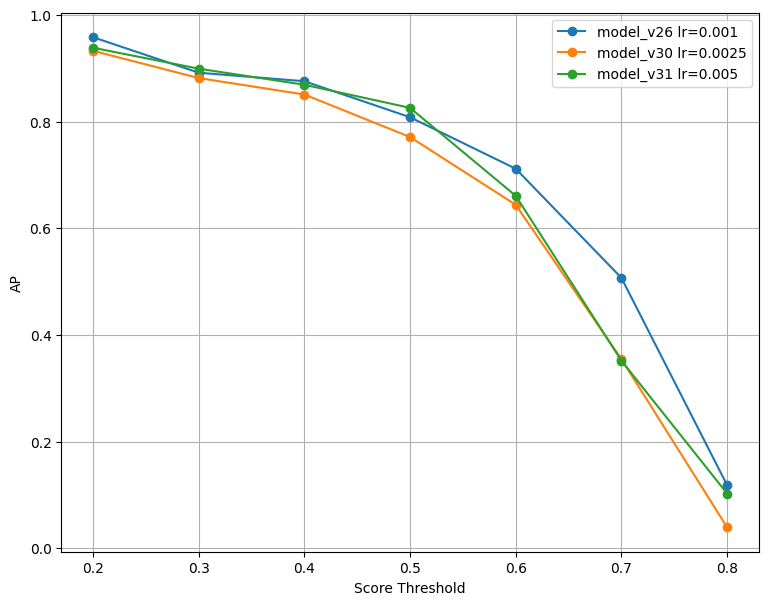

In [ ]:
import matplotlib.pyplot as plt

#learning rate
#segmentation values

score_thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

water_values = {
    "model_v26 lr=0.001": [0.7589, 0.7370, 0.6899, 0.6100, 0.4786, 0.3834, 0.2484],
    "model_v30 lr=0.0025": [0.7760, 0.7092, 0.6312, 0.5485, 0.4742, 0.3622, 0.2673],
    "model_v31 lr=0.005": [0.7426, 0.7156, 0.6580, 0.5741, 0.4210, 0.2898, 0.1985]
}

tomato_values = {
    "model_v26 lr=0.001": [0.5112, 0.3707, 0.3069, 0.2000, 0.1564, 0.1244, 0.0682],
    "model_v30 lr=0.0025": [0.6047, 0.4558, 0.3622, 0.2182, 0.1904, 0.1455, 0.0996],
    "model_v31 lr=0.005": [0.5837, 0.4964, 0.3878, 0.2542, 0.2191, 0.1611, 0.0754]
}

butter_values = {
    "model_v26 lr=0.001": [0.7449, 0.7449, 0.7400, 0.7277, 0.6892, 0.6494, 0.4922],
    "model_v30 lr=0.0025": [0.7366, 0.7366, 0.7234, 0.6956, 0.6942, 0.6283, 0.5352],
    "model_v31 lr=0.005": [0.7052, 0.7041, 0.6952, 0.6769, 0.6565, 0.5786, 0.3698]
}

salad_values = {
    "model_v26 lr=0.001": [0.4452, 0.3348, 0.2531, 0.1596, 0.1202, 0.0645, 0.0386],
    "model_v30 lr=0.0025": [0.3692, 0.2626, 0.2319, 0.1568, 0.0742, 0.0508, 0.0030],
    "model_v31 lr=0.005": [0.4750, 0.3921, 0.3168, 0.2189, 0.1827, 0.0909, 0.0397]
}

bread_values = {
    "model_v26 lr=0.001": [0.9582, 0.8917, 0.8757, 0.8082, 0.7117, 0.5071, 0.1186],
    "model_v30 lr=0.0025": [0.9327, 0.8817, 0.8508, 0.7711, 0.6441, 0.3547, 0.0396],
    "model_v31 lr=0.005": [0.9385, 0.8992, 0.8691, 0.8258, 0.6609, 0.3519, 0.1028]
}

mAP_values = {
    "model_v26 lr=0.001": [0.684, 0.616, 0.573, 0.501, 0.431, 0.346, 0.193],
    "model_v30 lr=0.0025": [0.6839, 0.6092, 0.5599, 0.4780, 0.4154, 0.3083, 0.1889],
    "model_v31 lr=0.005": [0.6890, 0.6415, 0.5854, 0.5100, 0.4281, 0.2945, 0.1572],
}

all_values = {
    "mAP": mAP_values,
    "Water": water_values,
    "Tomato": tomato_values,
    "Butter": butter_values,
    "Salad": salad_values,
    "Bread": bread_values,
}

for category_name, values in all_values.items():
    print(category_name)
    plt.figure(figsize=(9, 7))
    for model_name, AP in values.items():
        plt.plot(score_thresholds, AP, marker='o', label=model_name)
    plt.xlabel("Score Threshold")
    plt.ylabel("AP")
    plt.grid(True)
    plt.legend()
    plt.show()


mAP


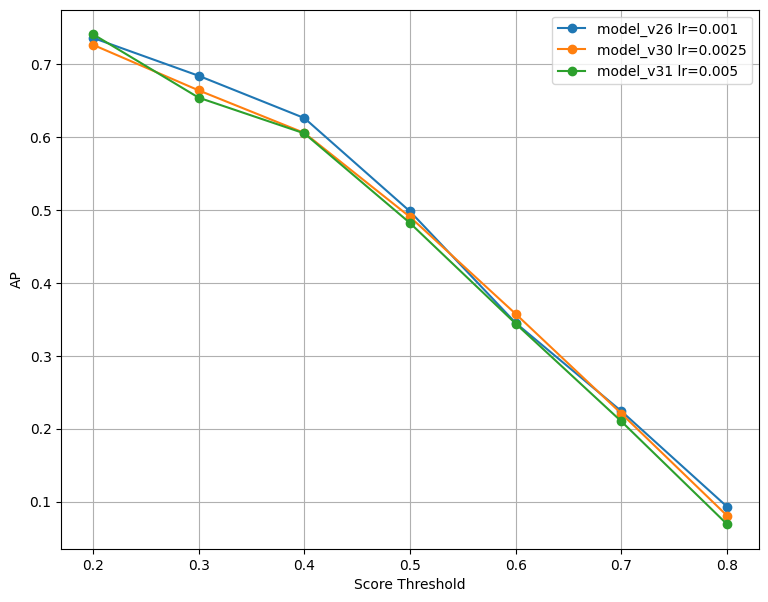

Water


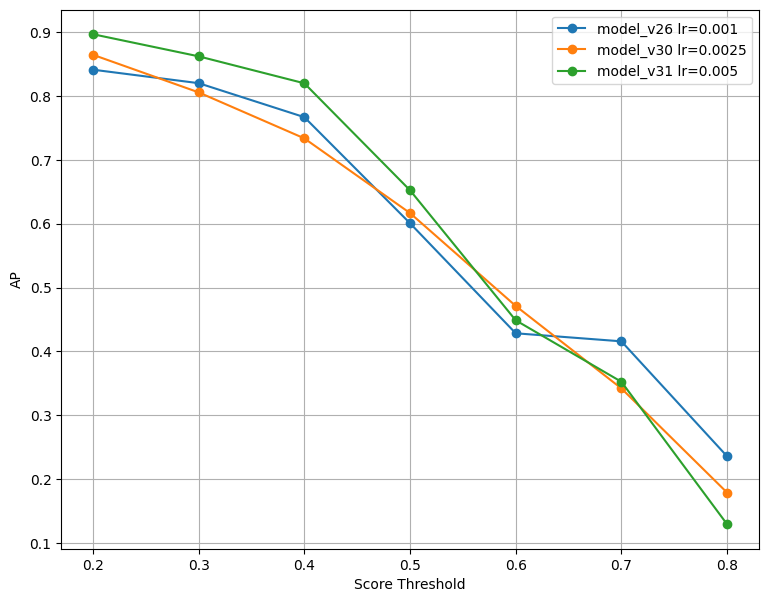

Tomato


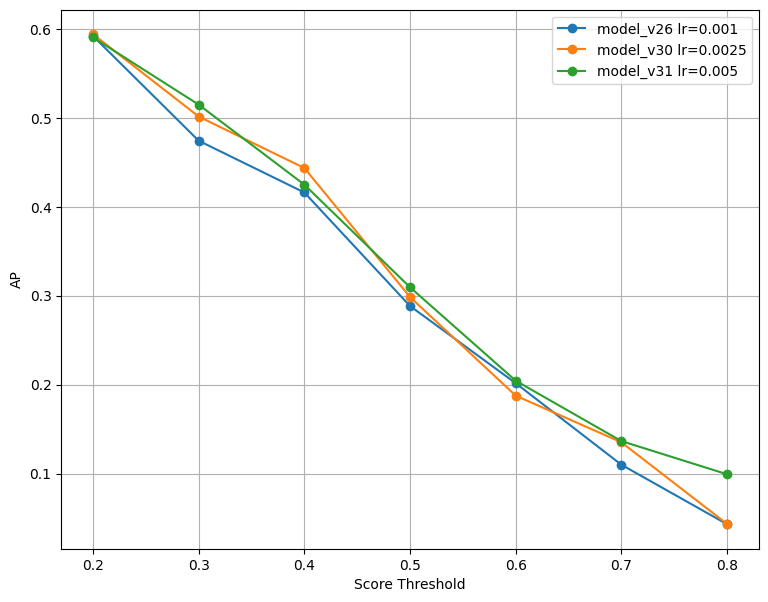

Butter


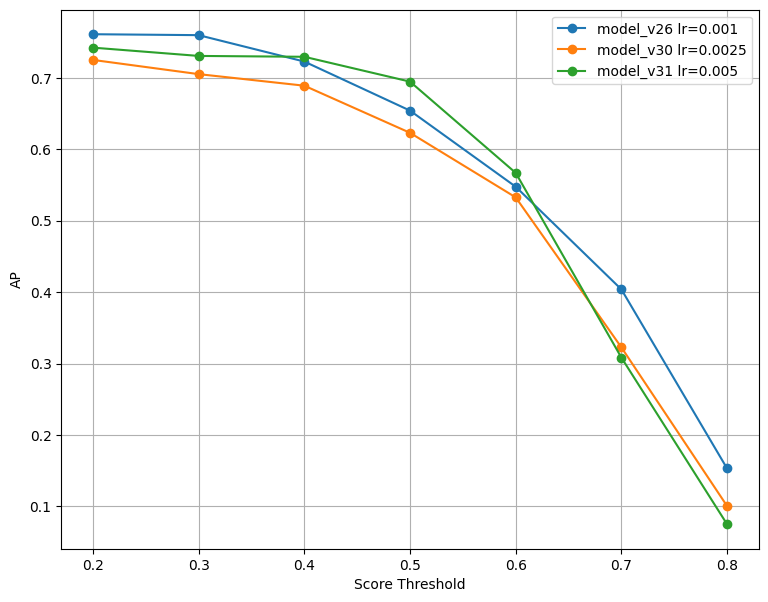

Salad


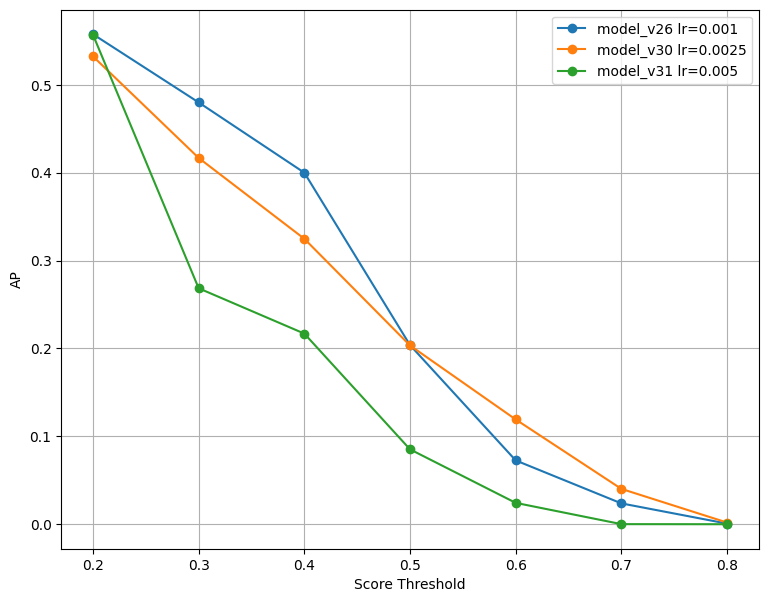

Bread


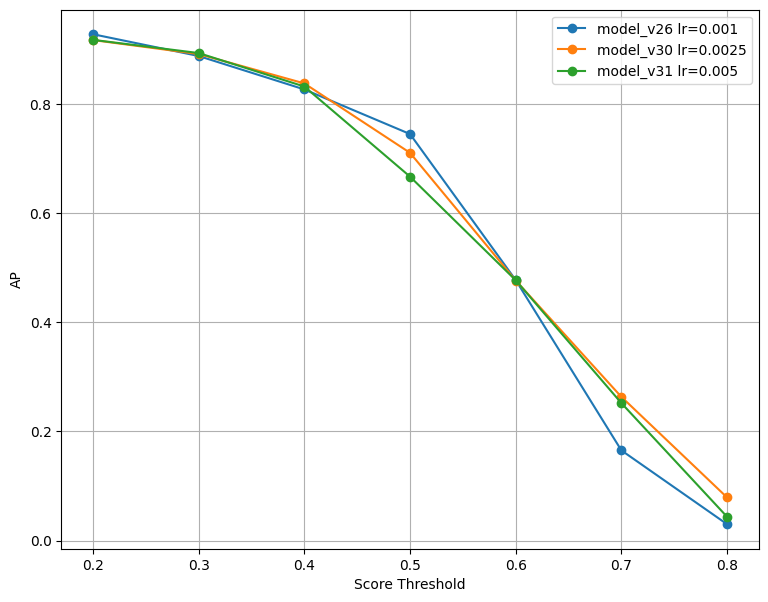

In [ ]:
import matplotlib.pyplot as plt

#learning rate
#bbox values

score_thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

water_values = {
    "model_v26 lr=0.001": [0.8410, 0.8199, 0.7667, 0.6007, 0.4285, 0.4159, 0.2360],
    "model_v30 lr=0.0025": [0.8643, 0.8055, 0.7335, 0.6166, 0.4713, 0.3422, 0.1792],
    "model_v31 lr=0.005": [0.8965, 0.8619, 0.8197, 0.6523, 0.4488, 0.3526, 0.1297]
}

tomato_values = {
    "model_v26 lr=0.001": [0.5921, 0.4743, 0.4161, 0.2884, 0.2016, 0.1099, 0.0430],
    "model_v30 lr=0.0025": [0.5941, 0.5015, 0.4436, 0.2985, 0.1876, 0.1351, 0.0433],
    "model_v31 lr=0.005": [0.5906, 0.5149, 0.4249, 0.3095, 0.2044, 0.1365, 0.0992]
}

butter_values = {
    "model_v26 lr=0.001": [0.7612, 0.7599, 0.7229, 0.6542, 0.5476, 0.4038, 0.1530],
    "model_v30 lr=0.0025": [0.7252, 0.7053, 0.6891, 0.6231, 0.5327, 0.3226, 0.1004],
    "model_v31 lr=0.005": [0.7424, 0.7308, 0.7296, 0.6948, 0.5670, 0.3083, 0.0749]
}

salad_values = {
    "model_v26 lr=0.001": [0.5576, 0.4800, 0.4000, 0.2038, 0.0726, 0.0237, 0.0007],
    "model_v30 lr=0.0025": [0.5324, 0.4168, 0.3248, 0.2034, 0.1192, 0.0402, 0.0019],
    "model_v31 lr=0.005": [0.5570, 0.2685, 0.2169, 0.0852, 0.0243, 0.0001, 0.0000]
}

bread_values = {
    "model_v26 lr=0.001": [0.9273, 0.8874, 0.8262, 0.7445, 0.4771, 0.1652, 0.0300],
    "model_v30 lr=0.0025": [0.9166, 0.8910, 0.8372, 0.7101, 0.4763, 0.2632, 0.0790],
    "model_v31 lr=0.005": [0.9170, 0.8928, 0.8315, 0.6665, 0.4768, 0.2518, 0.0436]
}

mAP_values = {
    "model_v26 lr=0.001": [0.736, 0.684, 0.626, 0.498, 0.345, 0.224, 0.093],
    "model_v30 lr=0.0025": [0.7265, 0.6640, 0.6056, 0.4904, 0.3574, 0.2207, 0.0807],
    "model_v31 lr=0.005": [0.741, 0.654, 0.605, 0.482, 0.344, 0.210, 0.069]
}

all_values = {
    "mAP": mAP_values,
    "Water": water_values,
    "Tomato": tomato_values,
    "Butter": butter_values,
    "Salad": salad_values,
    "Bread": bread_values,
}

for category_name, values in all_values.items():
    print(category_name)
    plt.figure(figsize=(9, 7))
    for model_name, AP in values.items():
        plt.plot(score_thresholds, AP, marker='o', label=model_name)
    plt.xlabel("Score Threshold")
    plt.ylabel("AP")
    plt.grid(True)
    plt.legend()
    plt.show()


In [ ]:
import matplotlib.pyplot as plt

#iterations
#segmentation values

score_thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

water_values = {
    "model_v26 it=1000": [0.7589, 0.7370, 0.6899, 0.6100, 0.4786, 0.3834, 0.2484],
    "model_v33 it=5000": [0.8377, 0.7962, 0.7539, 0.6477, 0.6295, 0.5288, 0.3112],
    "model_v35 it=10000":
}

tomato_values = {
    "model_v26 it=1000": [0.5112, 0.3707, 0.3069, 0.2000, 0.1564, 0.1244, 0.0682],
    "model_v33 it=5000": [0.7509, 0.6351, 0.4542, 0.2807, 0.2249, 0.1653, 0.1092],
    "model_v35 it=10000":
}

butter_values = {
    "model_v26 it=1000": [0.7449, 0.7449, 0.7400, 0.7277, 0.6892, 0.6494, 0.4922],
    "model_v33 it=5000": [0.7960, 0.7826, 0.7787, 0.7373, 0.7003, 0.6821, 0.5386],
    "model_v35 it=10000":
}

salad_values = {
    "model_v26 it=1000": [0.4452, 0.3348, 0.2531, 0.1596, 0.1202, 0.0645, 0.0386],
    "model_v33 it=5000": [0.6253, 0.4687, 0.4238, 0.3464, 0.2937, 0.1629, 0.0435],
    "model_v35 it=10000":
}

bread_values = {
    "model_v26 it=1000": [0.9582, 0.8917, 0.8757, 0.8082, 0.7117, 0.5071, 0.1186],
    "model_v33 it=5000": [0.9517, 0.9120, 0.8979, 0.8245, 0.6938, 0.5098, 0.1367],
    "model_v35 it=10000":
}

mAP_values = {
    "model_v26 it=1000": [0.684, 0.616, 0.573, 0.501, 0.431, 0.346, 0.193],
    "model_v33 it=5000": [0.792, 0.719, 0.662, 0.567, 0.508, 0.410, 0.228],
    "model_v35 it=10000":
}

all_values = {
    "mAP": mAP_values,
    "Water": water_values,
    "Tomato": tomato_values,
    "Butter": butter_values,
    "Salad": salad_values,
    "Bread": bread_values,
}

for category_name, values in all_values.items():
    print(category_name)
    plt.figure(figsize=(9, 7))
    for model_name, AP in values.items():
        plt.plot(score_thresholds, AP, marker='o', label=model_name)
    plt.xlabel("Score Threshold")
    plt.ylabel("AP")
    plt.grid(True)
    plt.legend()
    plt.show()


In [ ]:
import matplotlib.pyplot as plt

#iterations
#bbox values

score_thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

water_values = {
    "model_v26 it=1000": [0.8410, 0.8199, 0.7667, 0.6007, 0.4285, 0.4159, 0.2360],
    "model_v33 it=5000": [0.8826, 0.8621, 0.7830, 0.6648, 0.5082, 0.4230, 0.2267],
    "model_v35 it=10000":
}

tomato_values = {
    "model_v26 lr=0.001": [0.5921, 0.4743, 0.4161, 0.2884, 0.2016, 0.1099, 0.0430],
    "model_v33 it=5000": [0.6757, 0.5769, 0.4987, 0.3707, 0.2753, 0.1563, 0.1053],
    "model_v35 it=10000":
}

butter_values = {
    "model_v26 lr=0.001": [0.7612, 0.7599, 0.7229, 0.6542, 0.5476, 0.4038, 0.1530],
    "model_v33 it=5000": [0.7879, 0.7832, 0.7369, 0.6573, 0.4907, 0.4657, 0.1085],
    "model_v35 it=10000":
}

salad_values = {
    "model_v26 lr=0.001": [0.5576, 0.4800, 0.4000, 0.2038, 0.0726, 0.0237, 0.0007],
    "model_v33 it=5000": [0.6663, 0.6182, 0.5358, 0.2381, 0.1647, 0.0823, 0.0045],
    "model_v35 it=10000":
}

bread_values = {
    "model_v26 lr=0.001": [0.9273, 0.8874, 0.8262, 0.7445, 0.4771, 0.1652, 0.0300],
    "model_v33 it=5000": [0.9151, 0.8962, 0.8817, 0.7683, 0.5805, 0.3694, 0.0736],
    "model_v35 it=10000":
}

mAP_values = {
    "model_v26 lr=0.001": [0.736, 0.684, 0.626, 0.498, 0.345, 0.224, 0.093],
    "model_v33 it=5000": [0.786, 0.747, 0.687, 0.540, 0.404, 0.299, 0.104],
    "model_v35 it=10000":
}

all_values = {
    "mAP": mAP_values,
    "Water": water_values,
    "Tomato": tomato_values,
    "Butter": butter_values,
    "Salad": salad_values,
    "Bread": bread_values,
}

for category_name, values in all_values.items():
    print(category_name)
    plt.figure(figsize=(9, 7))
    for model_name, AP in values.items():
        plt.plot(score_thresholds, AP, marker='o', label=model_name)
    plt.xlabel("Score Threshold")
    plt.ylabel("AP")
    plt.grid(True)
    plt.legend()
    plt.show()
